# 0. Setup Paths

In [17]:
import os

In [18]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet-new-10000' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [19]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [20]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [21]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [22]:
import object_detection

# 2. Create Label Map

In [23]:
labels = [{'name':'scissors', 'id':1}, {'name':'rock', 'id':2}, {'name':'paper', 'id':3}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 8. Load Train Model From Checkpoint

In [24]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [25]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [26]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [27]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

# 9. Detect from an Image

In [28]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'scissors.5cb81bf9-0ff1-11ed-98e8-5cbaef51614e.jpg')

label :  scissors
Score : 0.92950034


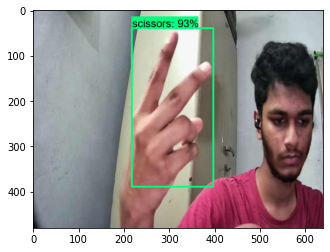

In [29]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

detections = detect_fn(input_tensor)
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
print("label : " , labels[detections['detection_classes'][0]]['name'])
print("Score :" , detections['detection_scores'][0])
plt.show()

# 10. Real Time Detections from your Webcam

In [ ]:
cap = cv2.VideoCapture(1)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=2,
                min_score_thresh=.5,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    if detections['detection_scores'][0] > 0.7 :
        print("label : " , labels[detections['detection_classes'][0]]['name'])
        print("Score :" , detections['detection_scores'][0])
        print("and : ")
        print("label : " , labels[detections['detection_classes'][1]]['name'])
        print("Score :" , detections['detection_scores'][1])
        print("--------------")
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

label :  rock
Score : 0.8726632
and : 
label :  paper
Score : 0.8523941
--------------
label :  rock
Score : 0.9673197
and : 
label :  paper
Score : 0.82959783
--------------
label :  paper
Score : 0.98479015
and : 
label :  paper
Score : 0.6732888
--------------
label :  paper
Score : 0.95034206
and : 
label :  paper
Score : 0.66014063
--------------
label :  paper
Score : 0.975889
and : 
label :  paper
Score : 0.8363785
--------------
label :  paper
Score : 0.9636667
and : 
label :  paper
Score : 0.8833992
--------------
label :  paper
Score : 0.9449684
and : 
label :  paper
Score : 0.902735
--------------
label :  paper
Score : 0.8897322
and : 
label :  paper
Score : 0.8765149
--------------
label :  paper
Score : 0.946192
and : 
label :  paper
Score : 0.8650435
--------------
label :  paper
Score : 0.8853846
and : 
label :  paper
Score : 0.7884193
--------------
label :  paper
Score : 0.95542115
and : 
label :  paper
Score : 0.8320485
--------------
label :  paper
Score : 0.9086515

label :  rock
Score : 0.9790768
and : 
label :  rock
Score : 0.12927778
--------------
label :  rock
Score : 0.9389552
and : 
label :  rock
Score : 0.08642379
--------------
label :  rock
Score : 0.9391142
and : 
label :  rock
Score : 0.108606115
--------------
label :  rock
Score : 0.94411653
and : 
label :  paper
Score : 0.07198972
--------------
label :  rock
Score : 0.9742193
and : 
label :  rock
Score : 0.09080009
--------------
label :  rock
Score : 0.91444665
and : 
label :  rock
Score : 0.05301966
--------------
label :  rock
Score : 0.9612732
and : 
label :  paper
Score : 0.099647105
--------------
label :  rock
Score : 0.8870509
and : 
label :  rock
Score : 0.21692972
--------------
label :  rock
Score : 0.75369155
and : 
label :  rock
Score : 0.17424257
--------------
label :  rock
Score : 0.77502
and : 
label :  rock
Score : 0.10104895
--------------
label :  rock
Score : 0.78770703
and : 
label :  rock
Score : 0.068264574
--------------
label :  rock
Score : 0.84902024
and

label :  paper
Score : 0.92810845
and : 
label :  paper
Score : 0.60845363
--------------
label :  paper
Score : 0.9213822
and : 
label :  paper
Score : 0.57429624
--------------
label :  paper
Score : 0.90139765
and : 
label :  paper
Score : 0.6109363
--------------
label :  paper
Score : 0.9076771
and : 
label :  paper
Score : 0.71965855
--------------
label :  paper
Score : 0.954468
and : 
label :  paper
Score : 0.07909466
--------------
label :  paper
Score : 0.86649674
and : 
label :  paper
Score : 0.13114053
--------------
label :  paper
Score : 0.8000421
and : 
label :  paper
Score : 0.3919239
--------------
label :  paper
Score : 0.7640423
and : 
label :  rock
Score : 0.06528914
--------------
label :  paper
Score : 0.8180502
and : 
label :  rock
Score : 0.073245265
--------------
label :  paper
Score : 0.8143697
and : 
label :  paper
Score : 0.11642123
--------------
label :  paper
Score : 0.84374225
and : 
label :  paper
Score : 0.22500142
--------------
label :  paper
Score 

label :  scissors
Score : 0.714636
and : 
label :  paper
Score : 0.07049044
--------------
label :  scissors
Score : 0.83391017
and : 
label :  paper
Score : 0.10710691
--------------
label :  scissors
Score : 0.94061476
and : 
label :  paper
Score : 0.10564127
--------------
label :  scissors
Score : 0.72184694
and : 
label :  paper
Score : 0.15797669
--------------
label :  scissors
Score : 0.7122397
and : 
label :  paper
Score : 0.19939151
--------------
label :  scissors
Score : 0.7658031
and : 
label :  paper
Score : 0.56293315
--------------
label :  rock
Score : 0.9201161
and : 
label :  rock
Score : 0.05990089
--------------
label :  rock
Score : 0.9801993
and : 
label :  paper
Score : 0.120878786
--------------
label :  rock
Score : 0.97992104
and : 
label :  paper
Score : 0.10993535
--------------
label :  rock
Score : 0.97970533
and : 
label :  paper
Score : 0.114109956
--------------
label :  rock
Score : 0.98032326
and : 
label :  paper
Score : 0.09232303
--------------
la

label :  scissors
Score : 0.81318337
and : 
label :  rock
Score : 0.1642961
--------------
label :  scissors
Score : 0.8066843
and : 
label :  paper
Score : 0.07053465
--------------
label :  scissors
Score : 0.75666904
and : 
label :  paper
Score : 0.059106424
--------------
label :  scissors
Score : 0.8811402
and : 
label :  paper
Score : 0.10470997
--------------
label :  scissors
Score : 0.7129932
and : 
label :  paper
Score : 0.14519615
--------------
label :  scissors
Score : 0.9201647
and : 
label :  paper
Score : 0.124416046
--------------
label :  scissors
Score : 0.91496855
and : 
label :  paper
Score : 0.17689088
--------------
label :  scissors
Score : 0.7957716
and : 
label :  paper
Score : 0.12248836
--------------
label :  scissors
Score : 0.8779577
and : 
label :  paper
Score : 0.061877117
--------------
label :  scissors
Score : 0.7923677
and : 
label :  paper
Score : 0.10399341
--------------
label :  scissors
Score : 0.74295926
and : 
label :  paper
Score : 0.1070143

label :  rock
Score : 0.9770827
and : 
label :  paper
Score : 0.10975082
--------------
label :  rock
Score : 0.9763433
and : 
label :  paper
Score : 0.1297458
--------------
label :  rock
Score : 0.979715
and : 
label :  paper
Score : 0.12827513
--------------
label :  rock
Score : 0.98135483
and : 
label :  paper
Score : 0.12043196
--------------
label :  rock
Score : 0.9814156
and : 
label :  paper
Score : 0.11904194
--------------
label :  rock
Score : 0.9802845
and : 
label :  paper
Score : 0.100766465
--------------
label :  rock
Score : 0.9813369
and : 
label :  paper
Score : 0.114311
--------------
label :  rock
Score : 0.98140496
and : 
label :  paper
Score : 0.115263045
--------------
label :  rock
Score : 0.97941047
and : 
label :  paper
Score : 0.11846909
--------------
label :  rock
Score : 0.9818548
and : 
label :  paper
Score : 0.11012526
--------------
label :  rock
Score : 0.9792498
and : 
label :  paper
Score : 0.10698463
--------------
label :  rock
Score : 0.9782622

label :  rock
Score : 0.79990435
and : 
label :  paper
Score : 0.02845249
--------------
label :  rock
Score : 0.72150266
and : 
label :  rock
Score : 0.02920611
--------------
label :  rock
Score : 0.7230232
and : 
label :  rock
Score : 0.036234245
--------------
label :  paper
Score : 0.9719009
and : 
label :  paper
Score : 0.049119595
--------------
label :  paper
Score : 0.723278
and : 
label :  paper
Score : 0.14954665
--------------
label :  paper
Score : 0.96874934
and : 
label :  paper
Score : 0.07635939
--------------
label :  paper
Score : 0.9829818
and : 
label :  paper
Score : 0.06193853
--------------
label :  paper
Score : 0.97803855
and : 
label :  paper
Score : 0.0712885
--------------
label :  paper
Score : 0.94964224
and : 
label :  paper
Score : 0.09119253
--------------
label :  paper
Score : 0.9441973
and : 
label :  paper
Score : 0.09178122
--------------
label :  paper
Score : 0.97821385
and : 
label :  paper
Score : 0.1237693
--------------
label :  paper
Score 

label :  rock
Score : 0.8810829
and : 
label :  rock
Score : 0.12803808
--------------
label :  rock
Score : 0.718936
and : 
label :  paper
Score : 0.039548393
--------------
label :  scissors
Score : 0.92710847
and : 
label :  paper
Score : 0.32422468
--------------
label :  scissors
Score : 0.7193862
and : 
label :  paper
Score : 0.25454286
--------------
label :  paper
Score : 0.8508636
and : 
label :  scissors
Score : 0.54328346
--------------
label :  paper
Score : 0.72376895
and : 
label :  scissors
Score : 0.64628375
--------------
label :  paper
Score : 0.77809143
and : 
label :  scissors
Score : 0.64550275
--------------
label :  paper
Score : 0.9211228
and : 
label :  scissors
Score : 0.7145192
--------------
label :  paper
Score : 0.9300956
and : 
label :  scissors
Score : 0.6789318
--------------
label :  paper
Score : 0.82131034
and : 
label :  scissors
Score : 0.7573831
--------------
label :  paper
Score : 0.8746051
and : 
label :  scissors
Score : 0.4106339
------------

label :  scissors
Score : 0.72266674
and : 
label :  paper
Score : 0.06423926
--------------
label :  scissors
Score : 0.7704699
and : 
label :  paper
Score : 0.06660892
--------------
label :  scissors
Score : 0.74426425
and : 
label :  paper
Score : 0.07678424
--------------
label :  scissors
Score : 0.77729326
and : 
label :  paper
Score : 0.09463165
--------------
label :  scissors
Score : 0.8713011
and : 
label :  paper
Score : 0.12743719
--------------
label :  scissors
Score : 0.79829454
and : 
label :  paper
Score : 0.09269162
--------------
label :  scissors
Score : 0.7901305
and : 
label :  paper
Score : 0.0815159
--------------
label :  scissors
Score : 0.8326019
and : 
label :  paper
Score : 0.07388911
--------------
label :  scissors
Score : 0.74845666
and : 
label :  paper
Score : 0.079921685
--------------
label :  scissors
Score : 0.8346305
and : 
label :  paper
Score : 0.07589924
--------------
label :  scissors
Score : 0.7100005
and : 
label :  paper
Score : 0.0578554

In [ ]:
# import the opencv library
import cv2


# define a video capture object
vid = cv2.VideoCapture(1)

while(True):
	
	# Capture the video frame
	# by frame
	ret, frame = vid.read()

	# Display the resulting frame
	cv2.imshow('frame', frame)
	
	# the 'q' button is set as the
	# quitting button you may use any
	# desired button of your choice
	if cv2.waitKey(1) & 0xFF == ord('q'):
		break

# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()


# 10. Freezing the Graph

In [ ]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [ ]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

# 11. Conversion to TFJS

In [ ]:
!pip install tensorflowjs

In [ ]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

# 12. Conversion to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
print(command)

In [ ]:
!{command}

# 13. Zip and Export Models 

In [ ]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')